In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
ionosphere_data = fetch_openml(name='ionosphere', version=1, as_frame=False)
X = ionosphere_data.data
y = ionosphere_data.target.astype('str')  # Convert target labels to strings
print("Dataset loaded.")


Dataset loaded.


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
# Define the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Bagging': BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Ensemble model with Stacking
estimators = [
    ('knn', classifiers['KNN']),
    ('rf', classifiers['Random Forest']),
    ('svm', classifiers['SVM'])
]
classifiers['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=5)

# Train and evaluate models using all features
results_all_features = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results_all_features[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None
    }


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
# Feature selection using Recursive Feature Elimination (RFE) with RandomForest
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
X_train_selected = rfe_selector.fit_transform(X_train, y_train)
X_test_selected = rfe_selector.transform(X_test)

# Train and evaluate models using selected features
results_selected_features = {}
for name, clf in classifiers.items():
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    results_selected_features[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': clf.predict_proba(X_test_selected) if hasattr(clf, "predict_proba") else None
    }


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
# Function to plot confusion matrices
def plot_confusion_matrices(results, title_suffix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    for idx, (name, result) in enumerate(results.items()):
        cm = result['confusion_matrix']
        cm_percent = cm / np.sum(cm, axis=1, keepdims=True) * 100
        sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=['b', 'g'], yticklabels=['b', 'g'], ax=axes[idx])
        axes[idx].set_title(f'{name} {title_suffix}')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curves
def plot_roc_curves(results, title_suffix):
    lb = LabelBinarizer()
    y_test_binary = lb.fit_transform(y_test)

    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        if result['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test_binary.ravel(), result['y_pred_proba'][:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} {title_suffix} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to print classification reports
def print_classification_reports(results, title_suffix):
    for name, result in results.items():
        print(f"\nClassification Report for {name} ({title_suffix}):")
        print(result['classification_report'])


Results using all features:

Classification Report for KNN (all features):
{'b': {'precision': 1.0, 'recall': 0.5897435897435898, 'f1-score': 0.7419354838709677, 'support': 39}, 'g': {'precision': 0.8072289156626506, 'recall': 1.0, 'f1-score': 0.8933333333333333, 'support': 67}, 'accuracy': 0.8490566037735849, 'macro avg': {'precision': 0.9036144578313253, 'recall': 0.7948717948717949, 'f1-score': 0.8176344086021505, 'support': 106}, 'weighted avg': {'precision': 0.8781541259377132, 'recall': 0.8490566037735849, 'f1-score': 0.8376303509839723, 'support': 106}}

Classification Report for Random Forest (all features):
{'b': {'precision': 0.9722222222222222, 'recall': 0.8974358974358975, 'f1-score': 0.9333333333333333, 'support': 39}, 'g': {'precision': 0.9428571428571428, 'recall': 0.9850746268656716, 'f1-score': 0.9635036496350364, 'support': 67}, 'accuracy': 0.9528301886792453, 'macro avg': {'precision': 0.9575396825396825, 'recall': 0.9412552621507846, 'f1-score': 0.9484184914841849, 

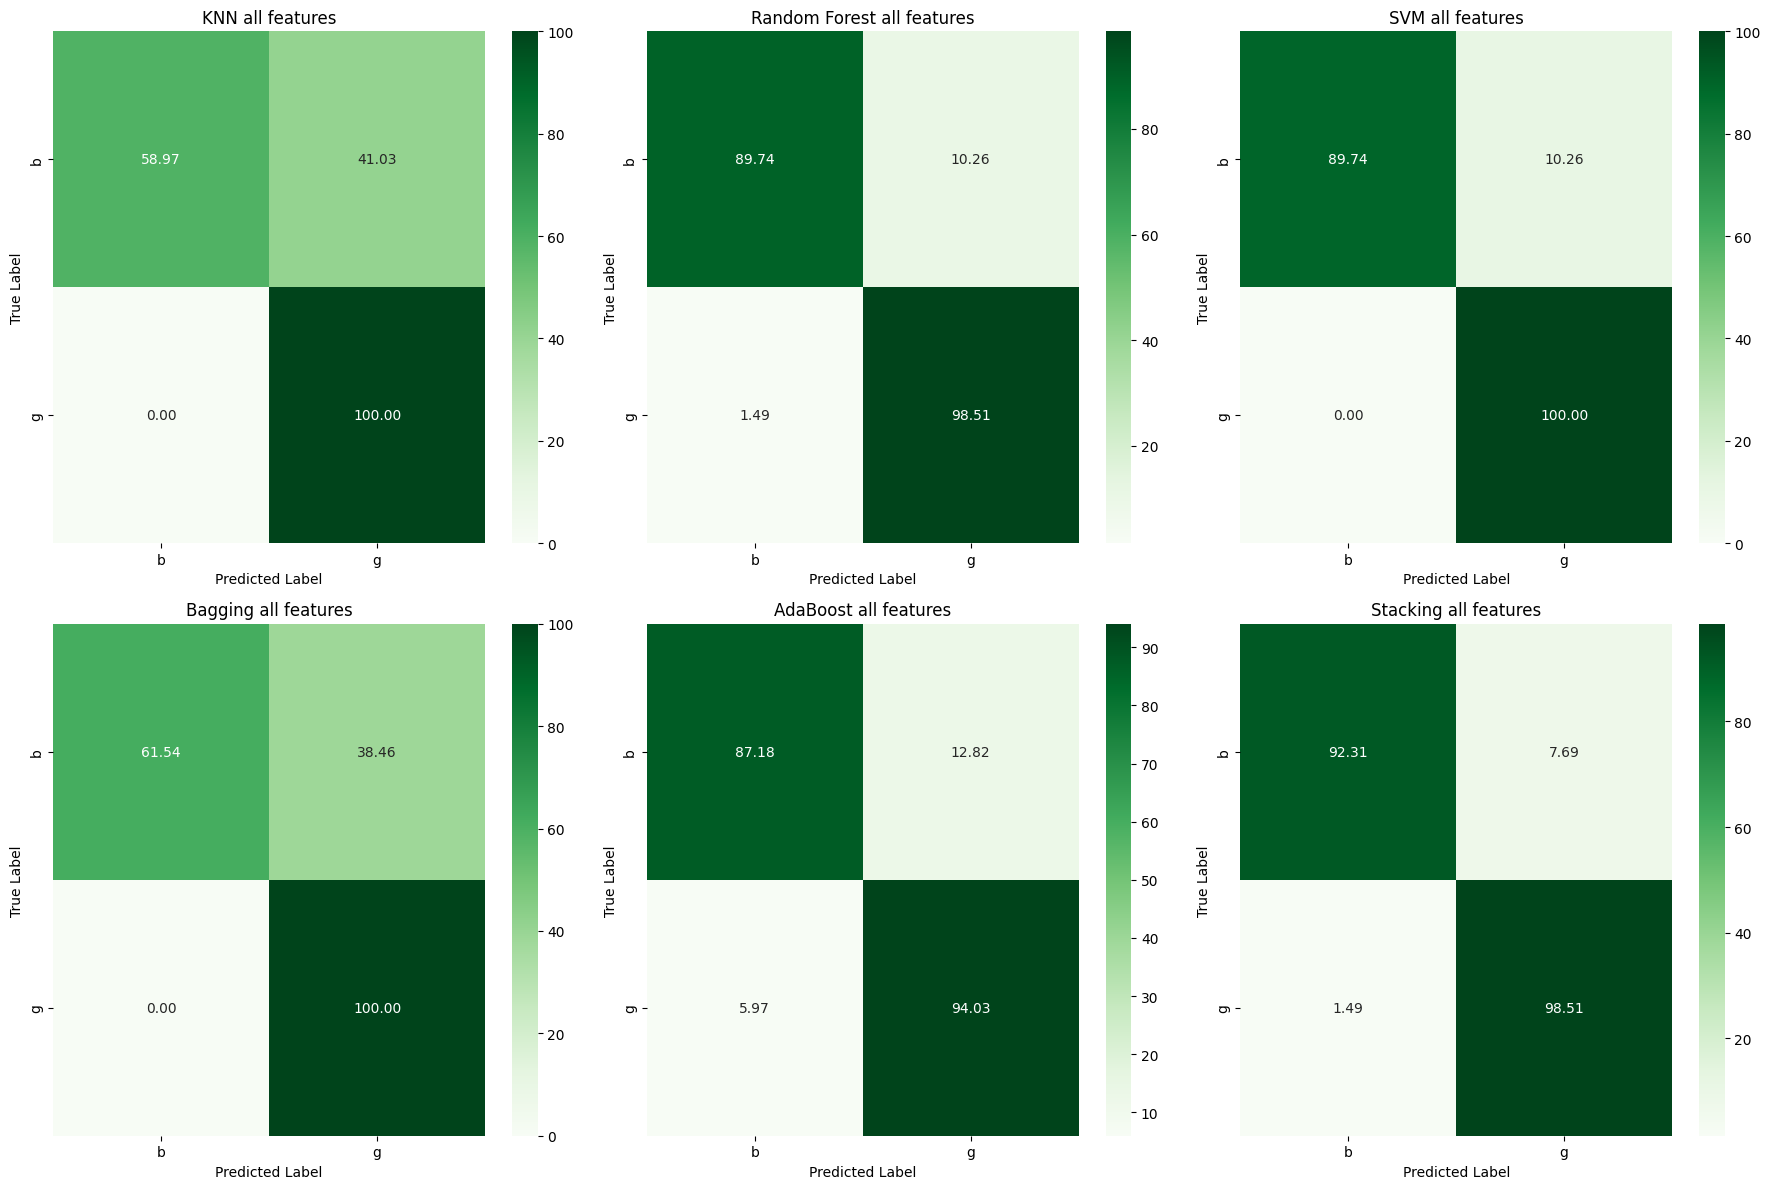

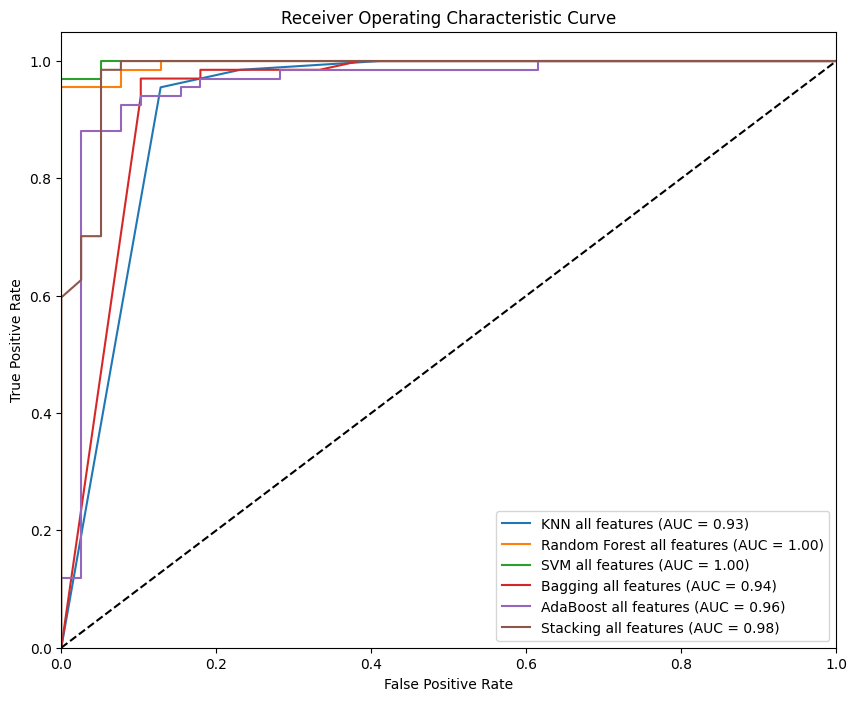

In [ ]:
# Results using all features
print("Results using all features:")
print_classification_reports(results_all_features, "all features")
plot_confusion_matrices(results_all_features, "all features")
plot_roc_curves(results_all_features, "all features")


Results using all features:

Classification Report for KNN (all features):
{'b': {'precision': 1.0, 'recall': 0.5897435897435898, 'f1-score': 0.7419354838709677, 'support': 39}, 'g': {'precision': 0.8072289156626506, 'recall': 1.0, 'f1-score': 0.8933333333333333, 'support': 67}, 'accuracy': 0.8490566037735849, 'macro avg': {'precision': 0.9036144578313253, 'recall': 0.7948717948717949, 'f1-score': 0.8176344086021505, 'support': 106}, 'weighted avg': {'precision': 0.8781541259377132, 'recall': 0.8490566037735849, 'f1-score': 0.8376303509839723, 'support': 106}}

Classification Report for Random Forest (all features):
{'b': {'precision': 0.9722222222222222, 'recall': 0.8974358974358975, 'f1-score': 0.9333333333333333, 'support': 39}, 'g': {'precision': 0.9428571428571428, 'recall': 0.9850746268656716, 'f1-score': 0.9635036496350364, 'support': 67}, 'accuracy': 0.9528301886792453, 'macro avg': {'precision': 0.9575396825396825, 'recall': 0.9412552621507846, 'f1-score': 0.9484184914841849, 

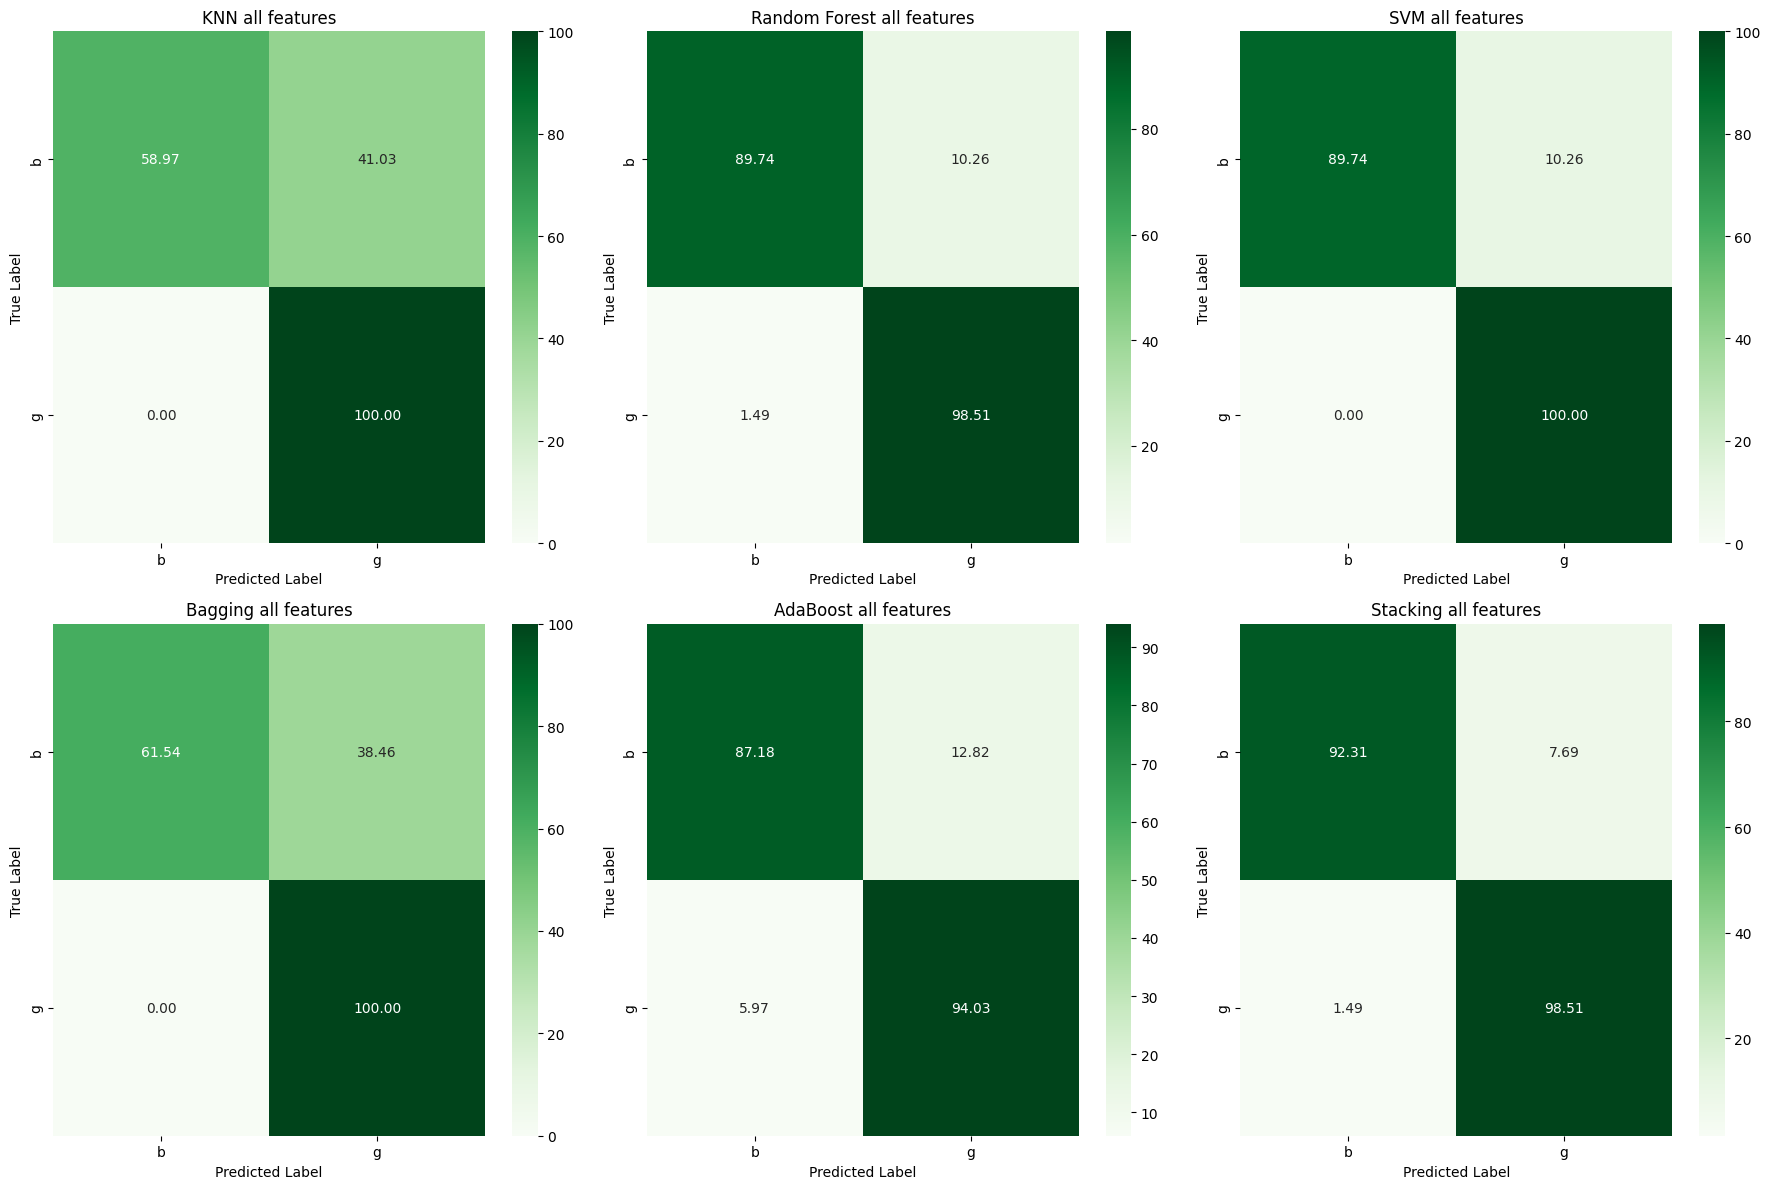

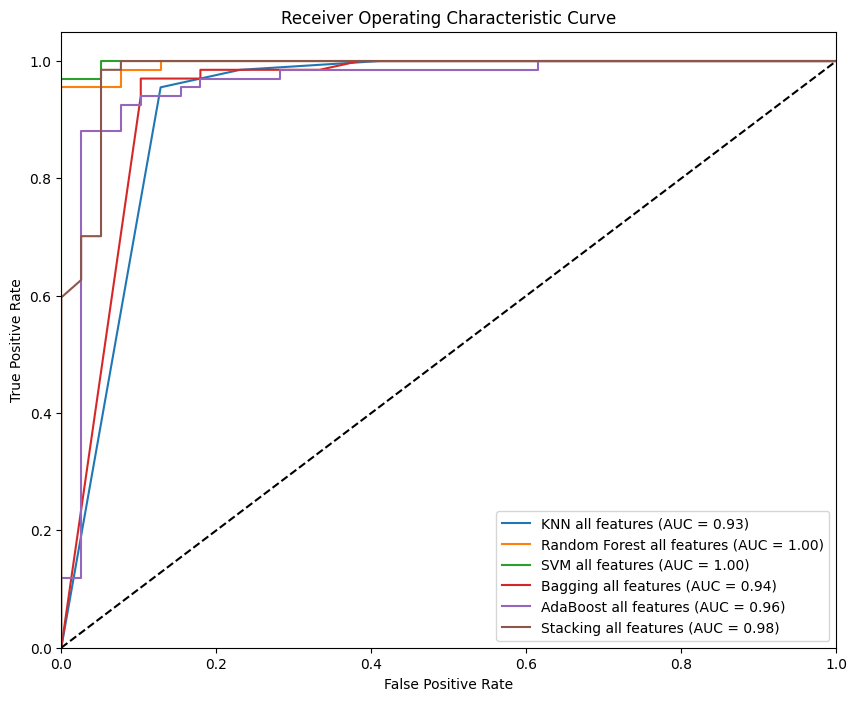

In [ ]:
# Results using all features
print("Results using all features:")
print_classification_reports(results_all_features, "all features")
plot_confusion_matrices(results_all_features, "all features")
plot_roc_curves(results_all_features, "all features")


Results using selected features:

Classification Report for KNN (selected features):
{'b': {'precision': 1.0, 'recall': 0.6923076923076923, 'f1-score': 0.8181818181818181, 'support': 39}, 'g': {'precision': 0.8481012658227848, 'recall': 1.0, 'f1-score': 0.9178082191780821, 'support': 67}, 'accuracy': 0.8867924528301887, 'macro avg': {'precision': 0.9240506329113924, 'recall': 0.8461538461538461, 'f1-score': 0.8679950186799501, 'support': 106}, 'weighted avg': {'precision': 0.9039885359445904, 'recall': 0.8867924528301887, 'f1-score': 0.881153222585117, 'support': 106}}

Classification Report for Random Forest (selected features):
{'b': {'precision': 0.9722222222222222, 'recall': 0.8974358974358975, 'f1-score': 0.9333333333333333, 'support': 39}, 'g': {'precision': 0.9428571428571428, 'recall': 0.9850746268656716, 'f1-score': 0.9635036496350364, 'support': 67}, 'accuracy': 0.9528301886792453, 'macro avg': {'precision': 0.9575396825396825, 'recall': 0.9412552621507846, 'f1-score': 0.9484

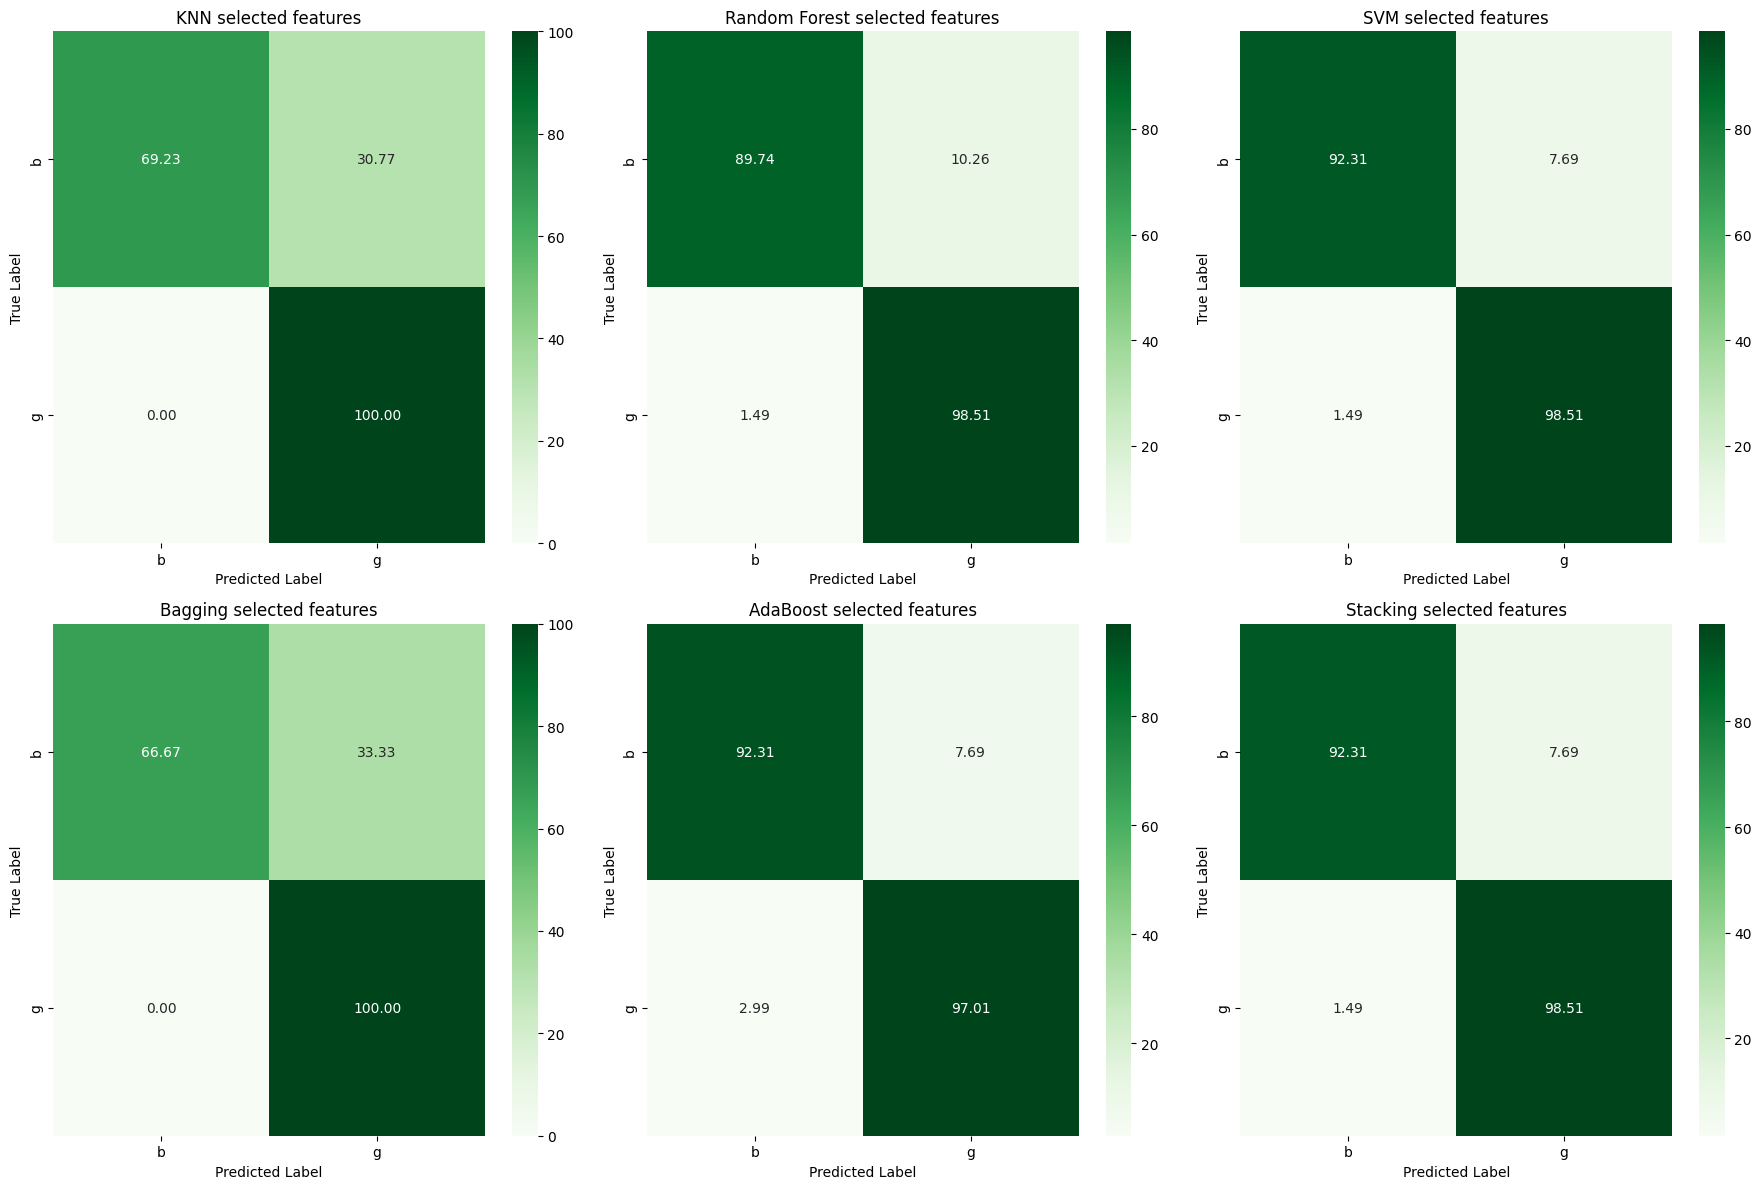

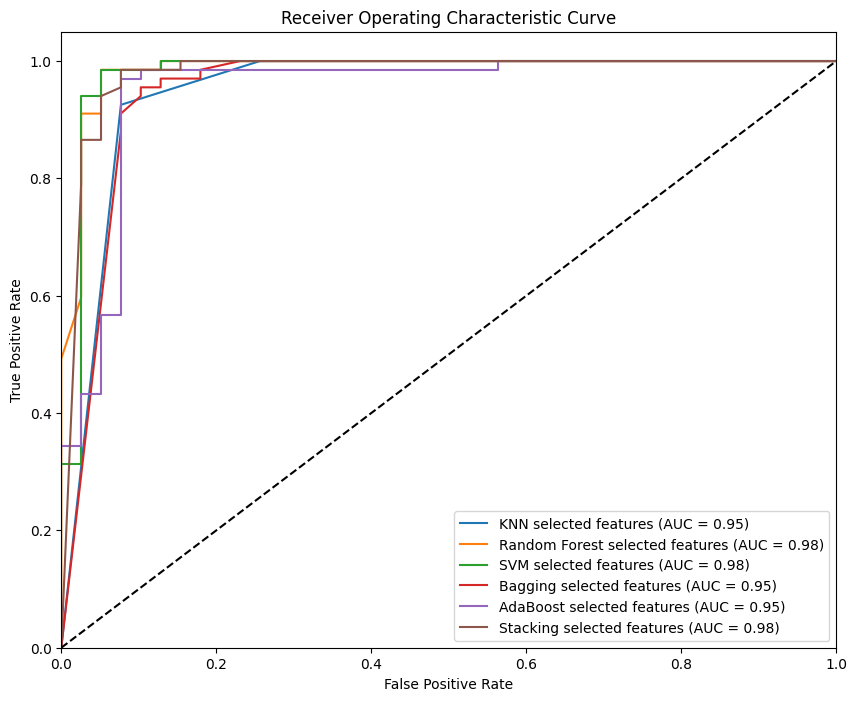

In [ ]:
# Results using selected features
print("Results using selected features:")
print_classification_reports(results_selected_features, "selected features")
plot_confusion_matrices(results_selected_features, "selected features")
plot_roc_curves(results_selected_features, "selected features")
